# Wasserstein Generative Adversarial Network with Gradient Penalty

This Jupyter Notebook implements a modified version of the Wasserstein Generative Adversarial Network with gradient penalty (WGAN-GP).
The main goal of this project is to be able to generate realistic looking synthetic fingerprint images that look as though they were sampled from the same probability distribution as the training dataset.

More specifically, the project focuses on generating damaged synthetic fingerprint images that display symptoms of skin disease.
To this end, the model is trained on the proprietary Database of Diseased Fingerprints created by Faculty of Information Technology at Brno University of Technology in cooperation with University Hospital Olomouc, St Anne's University Hospital in Brno and private dermatology clinic in Darmstadt.

---
---

## WGAN - GP Parameters

Parameters settings for the WGAN-GP model:

- `dataset_location` - specifies the location of the directory containing datasets. Ideally it is a location in the user's Google Drive or a Git repository.

- `dataset_name` - name of the dataset selects which of the available datasets should be in the `dataset_location` directory should be used for training.

- `save_file_path` - specifies the location where the model's checkpoints should be saved. It is recommended to save the checkpoint files to a personal Google Drive in order to prevent loss of these files in case the Google Colab VM terminates prematurely.

- `save_every` - number of epochs in between checkpointing of the WGAN-GP model

- `load_file_path` - specifies the location of existing model checkpoint files.
The program will look if `dataset_name+'_gen.pt'` and `dataset_name+'_gen.pt'` exist in given location. If they do not, new models will be initialized instead.

- `log_directory` - location of the log files that contain information about the training process of the network. Losses of generator, discriminator and gradient penalty will be saved there along with grids of samples generated at certain intervals of the model training.
---

- `image_size` - defines the $N \times N$ dimensions of the training and generated images. All of the images in the training dataset will be either resize or cropped to fit these dimensions. If you want to change the `image_size` it is also necessary to change the network architecture to accommodate these changes.

- `num_channels` - the number of channels in the training and generated images. Valid values for this parameter are either 1 or 3. The number of channels in the images from the training dataset will be adjusted automatically.

- `latent_dim` - number of latent dimensions in the random vectors `z` provided as inputs to the `Generator` network. This value of `latent_dim` should be greater or equal to the `image_size`

- `epochs` - total number of training epochs. One epoch consists of one cycle through the entire training dataset. The number of training steps in an epoch is dependent upon `batch_size`.

- `batch_size` - the dataset is divided into batches of size $N$.
This value specifies the number of training images sampled by the `DataLoader`, as well as the number of images created by the `Generator` for each training step of the network.

---

- `num_workers` - specifies the total number of worker processes used for data loading. If the value of this parameter is 0, single-process data loading is used instead.

- `use_cuda` - determines whether to use GPU acceleration if a CUDA-enabled GPU is available for use. 

In [1]:
import os

dataset_location = 'drive/MyDrive/_Datasets/'

dataset_name = 'FP_Atopic'
# dataset_name = 'FP_Dyshidrosis'
# dataset_name = 'FP_Psoriasis'

save_file_path = 'drive/MyDrive/_Models/'
save_every = 20

load_file_path = 'drive/MyDrive/_Models/'

log_dir = os.path.join(save_file_path, dataset_name+'_runs')

image_size = 256
num_channels = 1

latent_dim = image_size

epochs = 1
batch_size = 64

num_workers = 2
use_cuda = True

---
---

## Dependencies and Datasets

Download and install required dependencies if necessary.

- [Torchvision](https://pytorch.org/vision/stable/index.html) -  PyTorch package consisting of popular datasets, model architectures, and common image transformations for computer vision.
- [TensorboardX](https://tensorboardx.readthedocs.io/en/latest/tensorboard.html) - Python package allowing integration with TensorBoard visualization tool. Enables creation of logfiles compatible with TensorBoard
- [TorchGAN](https://torchgan.readthedocs.io/en/latest/) - Python package containing various GAN training utilities. 
- [TorchInfo](https://pypi.org/project/torchinfo/) - provides information similar to Tensorflow's `model.summary()` API to view the visualization of the model.
- [TorchSummary](https://pypi.org/project/torch-summary/) - older version of TorchInfo. Uses differently structured visualization of the model.

In [2]:
!pip install torchvision
!pip install tensorboardX
!pip install torchgan
!pip install torchinfo 
!pip install torchsummary

     |████████████████████████████████| 125 kB 11.4 MB/s 
     |████████████████████████████████| 71 kB 23 kB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=16f69a0d1014489b91ca791212d2b82abe330600c4c2a20839a422b1bb8df832
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

from torch import autograd
from torch.autograd import Variable

import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision.utils import make_grid
import torchvision.utils as vutils

from torch.utils.data import DataLoader, ConcatDataset, Subset

from torchgan.layers import SpectralNorm2d

import torchsummary
import torchinfo

# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter

## Download Dataset

To download the training dataset either copy the dataset from your Google Drive direct or clone a Git repository containing given dataset.

Any and all of the dataset files will be lost after the termination of the Google Colab VM and must be downloaded again on restart.

&nbsp;

---
Note: You could copy private repositories, but at that point it would be required to provide login credentials.

In [4]:
use_drive = True

if use_drive:

    dataset_dir = './'+dataset_name
    
    if not os.path.exists(dataset_dir):
        os.system("cp -R {}{} {}".format(dataset_location, dataset_name, dataset_dir))

else:
    # Specify user name and repository
    user = "USER_NAME"
    repository = "REPOSITORY_NAME"

    dataset_dir = "./"+repository+'/dataset'

    os.system("git clone https://github.com/{}/{}.git".format(user, repository))

print("Done downloading dataset {}.".format(dataset_name))

Done downloading dataset FP_Atopic.


### Data Loader

Data loader is a PyTorch utility for sampling data from the training dataset and organizing them into batches of size `batch_size`. Data loader transforms the input images before creating a batch of samples.

Data loader can have multiple workers working in parallel, but the default behavior is to reproduce the same random transformations in every worker.
The workers are therefore initialized with random seeds to allow each worker to create diffrent random transformations of the sampel images.


In [5]:
fill_value = 230 
rotation = 8
center_crop_size = int(1.4*image_size)
resize_crop_scale = (0.9,1.0)

# center_crop_size = int(1.6*image_size)

transform = transforms.Compose([
    transforms.RandomRotation(rotation, fill=fill_value),
    transforms.CenterCrop((center_crop_size, center_crop_size)),                              
    transforms.RandomResizedCrop(image_size, scale=resize_crop_scale),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=num_channels),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

train_dataset = dset.ImageFolder(root=dataset_dir, transform=transform)
    
def worker_init_fn(worker_id):
  np.random.seed(np.random.get_state()[1][0] + worker_id)

data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_init_fn)


print("Loading training data sample from folder '{}'.".format(dataset_dir))

Loading training data sample from folder './FP_Atopic'.


### Real Image Samples

Examples of real diseased fingerprint images taken from the training dataset before application of image transformations.

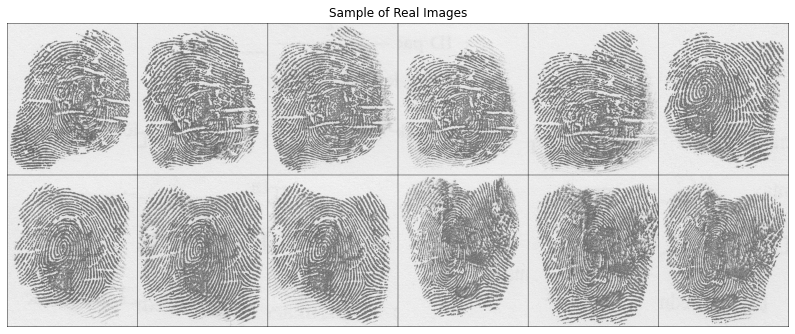

In [6]:
transform_subset = transforms.Compose([
    transforms.Resize((700,600)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

dataset_subset = dset.ImageFolder(root=dataset_dir, transform=transform_subset)
dataset_subset = torch.utils.data.Subset(dataset_subset, range(0,12))
subset_loader = torch.utils.data.DataLoader(dataset_subset, batch_size=12, num_workers=0, shuffle=False)

img_list = [image for image, _ in subset_loader][0]
img_list = vutils.make_grid(img_list, nrow=6, padding=2, normalize=True)
img_list = np.transpose(img_list, (1,2,0))

plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Sample of Real Images")
plt.imshow(img_list)
plt.show()

### Transformed Image Samples

Examples of transformed data samples of real diseased fingerprint images taken from the training dataset.

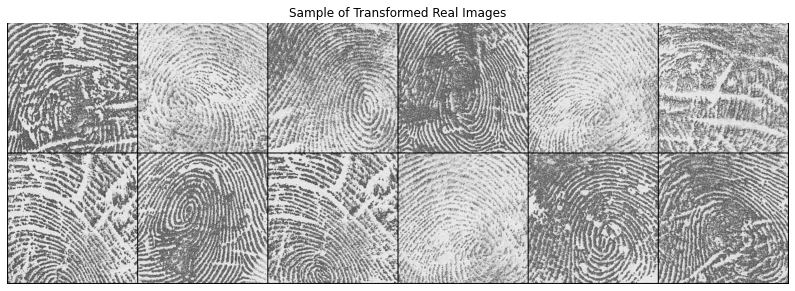

In [7]:
img_list = [image for image, _ in data_loader][0]
img_list = img_list[0:12]
img_list = vutils.make_grid(img_list, nrow=6, padding=2, normalize=True)
img_list = np.transpose(img_list, (1,2,0))

plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Sample of Transformed Real Images")
plt.imshow(img_list)
plt.show()

## Use GPU if available

Utilize GPU during training of the WGAN-GP model if the Google Colab VM is an instance with available GPU.

&nbsp;

If the runtime does not have GPU available by default, you can switch to a GPU runtime provided you have not exceeded the limits imposed by Google Colab.
To switch runtimes :
1. Select either option in the top toolbar:
  - `Runtime -> Change Runtime Type`
  - `Edit -> Notebook Settings`
2. Choose `GPU` in the `Hardware accelerator` dropdown menu.

If the Google Colab VM is running with available GPU, you should see an NVIDIA System Management Interface report printed in the cell's output. This should detail the specifications of the GPU available to you.

In [8]:
ngpu = 1

device = torch.device("cuda:0" if torch.cuda.is_available() and ngpu > 0 else "cpu")

if (device.type == "cuda"):
  !nvidia-smi
  print('Running on GPU.')
else:
  print('Running on CPU.')

Mon Mar 14 11:29:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
---

## WGAN - GP Model


### Utility

#### Dropout Module

The dropout module allows to keep track of dropout layers in the network and disable/enable dropout independent of normalization layers when required.

In [9]:
class DropoutModule():

    def __init__(self):
        super().__init__()

        self.dropout_probability = 0
        self.dropout_layers = []

    def new_dropout_layer(self):
        l = nn.Dropout(self.dropout_probability)
        self.dropout_layers.append(l)
        return l

    def disable_dropout(self):
        for dl in self.dropout_layers:
            dl.eval()  
        
    def enable_dropout(self):
        for dl in self.dropout_layers:
            dl.train()

#### View Module

The view module is used to change the shape of the input tensor.
Used for reshaping tensors in reshape and fully connected layers.

In [10]:
class View(nn.Module):

    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, input):
        batch_size = input.size(0)
        shape = (batch_size, *self.shape)
        out = input.view(shape)
        return out

#### Weights Initialization

Initialization of weights in the WGAN network using a normal distrbution $N(mean, std)$. For the purpouses of this model, the mean is $0$ and std is $0.02$.

In [11]:
def normal_init(m, mean=0, std=0.02):

    if isinstance(m, (nn.Linear, nn.Conv2d, nn.ConvTranspose2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
            
    elif isinstance(m, (nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

---
---

### Generator Model

The structure of the generator network $G$ consists of a series of *upsampling convolutional blocks*. An upsampling convolutional block consists of *Resize Convolution* followed by *Batch Normalization*, *Dropout* and application of the *ReLU* activation function.

- Input - batch of randomly sampled input vectors $z \in R^{|latent\_dim|}$
- Output - batch of generated images $x \in R^{|image\_size \times image\_size|}$

&nbsp;

The structure of the network is a series of layers:

1. Fully connected reshape layer, Batch Normalization, ReLU
2. Upsampling block
3. Upsampling block
4. Upsampling block
5. Upsampling block
6. Upsampling block
7. Resize convolution, Tanh



In [12]:
class Generator(DropoutModule, torch.nn.Module):
    def __init__(self, latent_dim, d=32, channels=1):
        super().__init__()

        # Input_Volume = (batch_size, latent_dim, 1, 1)
        # Output_Volume = (batch_size, num_channels, 128, 128)

        self.dropout_probability = 0.4

        # Kernel size, Stride and Padding for inner layers
        k = 3
        s = 1
        p = 1

        self.resize = nn.Sequential(
            # State (latent_dim x1x1)
            *self.reshape_layer(latent_dim, d * 32, batch_norm=True, dropout=False, relu=True),
            # State (1024x4x4)
        )

        self.main_module = nn.Sequential(
            # State (1024x4x4)
            *self.deconv_layer(d * 32, d * 16, k, s, p, resize_conv=True, batch_norm=True, dropout=True, relu=True),
            # State (512x8x8)
            *self.deconv_layer(d * 16, d * 8, k, s, p, resize_conv=True, batch_norm=True, dropout=True, relu=True),
            # State (256x16x16)
            *self.deconv_layer(d * 8, d * 4, k, s, p, resize_conv=True, batch_norm=True, dropout=True, relu=True),
            # State (128x32x32)
            *self.deconv_layer(d * 4, d * 2, k, s, p, resize_conv=True, batch_norm=True, dropout=True, relu=True),
            # State (64x64x64)
            *self.deconv_layer(d * 2, d * 1, k, s, p, resize_conv=True, batch_norm=True, dropout=True, relu=True),
            # State (32x128x128)
        )

        self.output = nn.Sequential(
            # State (32x128x128)
            *self.deconv_layer(d * 1, channels, k, s, p, resize_conv=True, batch_norm=False, dropout=False, relu=False), nn.Tanh(),
            # State (Cx256x256)
        )

        self.weight_init()



    def reshape_layer(self, latent_dim, out_channels, batch_norm=True, dropout=False, relu=True):
        layer = []
        layer.append(nn.Linear(latent_dim, out_channels * 4 * 4))
        layer.append(View((out_channels, 4, 4)))
        if batch_norm:    layer.append(nn.BatchNorm2d(out_channels))  
        if dropout:       layer.append(self.new_dropout_layer())
        if relu:          layer.append(nn.ReLU(inplace=True))  

        return layer



    def deconv_layer(self, in_channels, out_channels, kernel_size, stride, padding,
                          resize_conv=False, batch_norm=False, dropout=False, relu=False):
        layer = []

        if resize_conv:
                          layer.append(nn.Upsample(scale_factor=2, mode='nearest'))
                          layer.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
        else:             layer.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))    
        if batch_norm:    layer.append(nn.BatchNorm2d(out_channels))  
        if dropout:       layer.append(self.new_dropout_layer())
        if relu:          layer.append(nn.ReLU(inplace=True))
        
        return layer



    def _resize(self, x):
        print(self.resize)
        return self.resize(x)



    def forward(self, z):
        resized = self.resize(z)
        g_z = self.main_module(resized)
        return self.output(g_z)



    def weight_init(self):
        for block in self._modules:
            try:
                for m in self._modules[block]:
                    normal_init(m,mean,std)
            except:
                normal_init(block)



# Initialize a temporary generator network and display its structure
g = Generator(latent_dim).to(device)
input_shape = (batch_size, 1, 1, latent_dim)

# print(torchsummary.summary(g, input_shape[1:], batch_size=batch_size))
print(torchinfo.summary(g, input_size=input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [64, 1024, 4, 4]          --
│    └─Linear: 2-1                       [64, 1, 1, 16384]         4,210,688
│    └─View: 2-2                         [64, 1024, 4, 4]          --
│    └─BatchNorm2d: 2-3                  [64, 1024, 4, 4]          2,048
│    └─ReLU: 2-4                         [64, 1024, 4, 4]          --
├─Sequential: 1-2                        [64, 32, 128, 128]        --
│    └─Upsample: 2-5                     [64, 1024, 8, 8]          --
│    └─Conv2d: 2-6                       [64, 512, 8, 8]           4,719,104
│    └─BatchNorm2d: 2-7                  [64, 512, 8, 8]           1,024
│    └─Dropout: 2-8                      [64, 512, 8, 8]           --
│    └─ReLU: 2-9                         [64, 512, 8, 8]           --
│    └─Upsample: 2-10                    [64, 512, 16, 16]       

### Discriminator Model

The structure of the discriminator network $D$ consists of a series of *downsampling convolutional blocks*. A downsampling convolutional block consists of *Strided Convolution* followed by *Spectral Normalization*, *Dropout* and application of the *LeakyReLU* activation function.

- Input - batch of real or fake image samples  $x \in R^{|image\_size \times image\_size|}$
- Output - batch of Wasserstein distance metrics

&nbsp;

The structure of the network is a series of layers:

1. Downsampling block
2. Downsampling block
3. Downsampling block
4. Downsampling block
5. Downsampling block
6. Strided convolution, spectral normalization, LeakyReLU
7. Fully connected layer


In [13]:
class Discriminator(DropoutModule, nn.Module):
  
    def __init__(self, d=32, input_channels=1):
        super().__init__()

        # Input_Volume = (batch_size, num_channels, 128, 128)
        # Output_Volume = (batch_size, 1, 1, 1)

        self.dropout_probability = 0.4

        # Kernel size, Stride and Padding for the inner layers
        k = 3
        s = 2
        p = 1

        self.main_module = nn.Sequential(
            # State: (1x256x256)
            *self.conv_layer(input_channels, d * 4, k, s, p, spec_norm=True, dropout=True, leaky=True),
            # State: (128x128x128)
            *self.conv_layer(d * 4, d * 8, k, s, p, spec_norm=True, dropout=True, leaky=True),
            # State: (256x64x64)
            *self.conv_layer(d * 8, d * 16, k, s, p, spec_norm=True, dropout=True, leaky=True),
            # State (512x32x32)
            *self.conv_layer(d * 16, d * 16, k, s, p, spec_norm=True, dropout=True, leaky=True),
            # State (512x16x16)
            *self.conv_layer(d * 16, d * 16, k, s, p, spec_norm=True, dropout=True, leaky=True),
            # State (512x8x8)
            *self.conv_layer(d * 16, d * 32, k, s, p, spec_norm=True, dropout=False, leaky=True)
            # State (1024x4x4)
        )

        self.output = nn.Sequential(
            # State (1024x4x4)
            *self.output_layer(d * 32 * 4 * 4),
            # State (1x1x1)
        )
        
        self.weight_init()



    def conv_layer(self, in_channels, out_channels, kernel_size, stride, padding, spec_norm=False, dropout=False, leaky=True):
        layer = []

        if spec_norm:
                        layer.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
                        layer.append(SpectralNorm2d(nn.Conv2d(out_channels, out_channels, 1, 1, 0)))
        
        else:           layer.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))      
        
        if dropout:     layer.append(self.new_dropout_layer())
            
        if leaky:       layer.append(nn.LeakyReLU(0.2, inplace=True))

        return layer



    def output_layer(self, in_channels):
        layer = []
        layer.append(View((1, 1, in_channels)))
        layer.append(nn.Linear(in_channels, 1))

        return layer



    def forward(self, x):
        d_x = self.main_module(x)
        return self.output(d_x)



    def weight_init(self):
        for block in self._modules:
            try:
                for m in self._modules[block]:
                    normal_init(m,mean,std)
            except:
                normal_init(block)



# Initialize a temporary discriminator network and display its structure
d = Discriminator().to(device)
input_shape = (batch_size, 1, image_size, image_size)

# print(torchsummary.summary(d, input_shape[1:], batch_size=batch_size))
print(torchinfo.summary(d, input_size=input_shape))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [64, 1024, 4, 4]          --
│    └─Conv2d: 2-1                       [64, 128, 128, 128]       1,280
│    └─SpectralNorm2d: 2-2               [64, 128, 128, 128]       --
│    └─Dropout: 2-3                      [64, 128, 128, 128]       --
│    └─LeakyReLU: 2-4                    [64, 128, 128, 128]       --
│    └─Conv2d: 2-5                       [64, 256, 64, 64]         295,168
│    └─SpectralNorm2d: 2-6               [64, 256, 64, 64]         --
│    └─Dropout: 2-7                      [64, 256, 64, 64]         --
│    └─LeakyReLU: 2-8                    [64, 256, 64, 64]         --
│    └─Conv2d: 2-9                       [64, 512, 32, 32]         1,180,160
│    └─SpectralNorm2d: 2-10              [64, 512, 32, 32]         --
│    └─Dropout: 2-11                     [64, 512, 32, 32]         --


### WGAN - GP Model

This implementation of the WGAN-GP model is an extension of [WGAN-GP](https://github.com/arturml/pytorch-wgan-gp) by Artur Lacerda.

This module contains the two CNN models of generator and discriminator as well as their respective Adam optimizers. It is responsible for training of these networks.

&nbsp;

A training epoch of the model consists of multiple training steps. The number of training steps in an epoch is dependent upon the `batch_size` and the total size of the training dataset. For every training step of the generator network, the discriminator makes `n_critic` $\geq 1$ training steps.

&nbsp;

Training step of the discriminator network $D$ consists of computing Wassertein distance. The distance is computed from batches of real data $x$, fake data $\tilde{x}$ and points $\hat{x}$ drawn uniformly from between $x$ and $\tilde{x}$.

$\epsilon \sim U[0,1]$ \\
$\hat{x} = \epsilon x + (1 - \epsilon)\tilde{x}$

&nbsp;

$W^{(D)}_i = - D(x) + D(\tilde{x}) + GP$ \\
$GP = \lambda (|| \nabla_{\hat{x}} D(\hat{x})||_2 - 1)^2 $ 

&nbsp;

Training step of the generator network $G$ consists of evaluating a batch of generated samples $\tilde{x} = G(z), \,\, z \in R^{|latent\_dim|}$ using the discriminator network $D$.

$J^{(G)}_i = - D(\tilde{x})$


In [14]:
class WGANGP():

    def __init__(self, generator, discriminator, g_optmizer, d_optimizer,
                 latent_shape, dataset_name, n_critic=3, lmbda=10, fixed_z=None,
                 save_every=20, use_cuda=True, log_dir=None, save_path='/'):

        self.G = generator
        self.D = discriminator

        self.G_optimizer = g_optmizer
        self.D_optimizer = d_optimizer

        self.latent_shape = latent_shape

        self.n_critic = n_critic
        self.lmbda = lmbda

        self.dataset_name = dataset_name
        self.save_every = save_every
        self.save_path = save_path
        self.log_dir = log_dir
        self.writer = SummaryWriter(log_dir)

        self.step = 0
        self.epoch = 0
      
        if fixed_z is not None:
            self._fixed_z = fixed_z
        else:
            self._fixed_z = torch.randn(16, *latent_shape)

        self.use_cuda = use_cuda

        if self.use_cuda:
            self._fixed_z = self._fixed_z.cuda()
            self.G.cuda()
            self.D.cuda()



    def train(self, data_loader, n_epochs, checkpoint_epoch=0, checkpoint_step=0):

        self.epoch = checkpoint_epoch
        self.step = checkpoint_step

        for img_list in range(1, n_epochs + 1):

            np.random.seed(9875+ epoch)

            self.epoch += 1
            self._train_epoch(data_loader)

            if self.epoch % self.save_every == 0 or epoch == n_epochs:
                self._save_checkpoint()
            
            if self.epoch % 100 == 0:
                self._save_grid()

        self.writer.flush()
        self.writer.close()



    def _train_epoch(self, data_loader):
        g_loss = 0.0
        d_loss = 0.0

        print('Training epoch {}:'.format(self.epoch))
      
        for i, (data, _) in enumerate(data_loader, 0):

            self.step += 1

            data = Variable(data)
            if self.use_cuda:
                data = data.cuda()

            d_loss, grad_penalty = self._discriminator_train_step(data)

            if self.step % self.n_critic == 0:
                g_loss = self._generator_train_step(data.size(0))

                self.writer.add_scalars('losses', {'d_loss': d_loss, 'grad_penalty': grad_penalty}, self.step)
                self.writer.add_scalars('losses', {'g_loss': g_loss}, self.step)

        print('    g_loss: {:.3f} d_loss: {:.3f} grad_pen: {:.3f}'.format(g_loss, d_loss, grad_penalty))



    def _discriminator_train_step(self, data):
        batch_size = data.size(0)
        generated_data = self._sample(batch_size)

        grad_penalty = self._gradient_penalty(data, generated_data)

        # Loss of the discriminator
        # W^(D) = - D(x) + D(x_tilde) + gradient penalty
        d_loss = - self.D(data).mean() + self.D(generated_data).mean() + grad_penalty

        self.D_optimizer.zero_grad()
        d_loss.backward()
        self.D_optimizer.step()

        return d_loss.item(), grad_penalty.item()



    def _generator_train_step(self, batch_size):
        self.G_optimizer.zero_grad()
        generated_data = self._sample(batch_size)
        
        self.D.eval()
        # Loss of generator network
        # J^(G) = -D(G(z))
        g_loss = -self.D(generated_data).mean()
        self.D.train()
        
        g_loss.backward()
        self.G_optimizer.step()

        return g_loss.item()



    def _gradient_penalty(self, data, generated_data, lmbda=10):
        batch_size = data.size(0)
        
        # Random vector epsilon sampled from distribution U[0,1]
        epsilon = torch.rand(batch_size, 1, 1, 1)
        epsilon = epsilon.expand_as(data)

        if self.use_cuda:
            epsilon = epsilon.cuda()

        # Sample interpolation
        # x is a real data sample
        # x_tilde is a generated sample
        # x_hat = epsilon * x + (1 - epsilon) * x_tilde 
        interpolation = epsilon * data.data + (1 - epsilon) * generated_data.data
        interpolation = Variable(interpolation, requires_grad=True)

        if self.use_cuda:
            interpolation = interpolation.cuda()

        interpolation_logits = self.D(interpolation)
        grad_outputs = torch.ones(interpolation_logits.size())

        if self.use_cuda:
            grad_outputs = grad_outputs.cuda()

        gradients = autograd.grad(outputs=interpolation_logits,
                                  inputs=interpolation,
                                  grad_outputs=grad_outputs,
                                  create_graph=True,
                                  retain_graph=True)[0]

        gradients = gradients.view(batch_size, -1)
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Gradient penalty
        # gp = lambda * (|| Gradient of x_hat ||_2 - 1)^2
        return self.lmbda * ((gradients_norm - 1) ** 2).mean()



    def _sample(self, n_samples):
        z = Variable(torch.randn(n_samples, *self.latent_shape))
        if self.use_cuda:
            z = z.cuda()

        return self.G(z)



    def _save_grid(self):
        z = self._fixed_z[0:4]
        samples = self.G(z).cpu().data
        log_img_dir = os.path.join(log_dir,'imgs')
        save_file_path = os.path.join(log_img_dir, dataset_name+'_{}.png'.format(self.epoch))
        vutils.save_image(samples, save_file_path, normalize=True)



    def _save_checkpoint(self):
        checkpoint =  {
            'epoch': self.epoch,
            'step': self.step,
            'fixed_z': self._fixed_z,
            'model_state_dict': self.G.state_dict(),
            'optimizer_state_dict': self.G_optimizer.state_dict(),
        } 
        torch.save(checkpoint, self.save_path + self.dataset_name + '_gen.pt')

        checkpoint =  {
            'epoch': self.epoch,
            'step': self.step,
            'fixed_z': self._fixed_z,
            'model_state_dict': self.D.state_dict(),
            'optimizer_state_dict': self.D_optimizer.state_dict(),
        } 
        torch.save(checkpoint, self.save_path + self.dataset_name + '_disc.pt')    



    def _plot_grid(self):
        self.G.eval()
        img_list = vutils.make_grid(self.G(self._fixed_z), nrow=4, padding=2, normalize=True)
        self.G.train()
        img_list = list(map((lambda x: x.cpu().numpy()), img_list))

        plt.clf()
        plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.imshow(np.transpose(img_list, (1,2,0)))
        plt.show()

---
---

## Training the WGAN-GP



### Loading Existing Models



In [15]:
if not os.path.exists(save_file_path):
    save_file_path = '/models'

if not os.path.exists(load_file_path):
    raise NotADirectoryError

gen_path = load_file_path+dataset_name+'_gen.pt'
disc_path = load_file_path+dataset_name+'_disc.pt'

if os.path.exists(gen_path) and os.path.exists(disc_path):
  generator = Generator(latent_dim, channels=num_channels)
  discriminator = Discriminator(input_channels=num_channels)

  gen_checkpoint = torch.load(gen_path, map_location=device)
  generator.load_state_dict(gen_checkpoint['model_state_dict'])
  generator.to(device)

  disc_checkpoint = torch.load(disc_path, map_location=device)
  discriminator.load_state_dict(disc_checkpoint['model_state_dict'])
  discriminator.to(device)

  g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.1, 0.9))
  d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.1, 0.9))

  g_optimizer.load_state_dict(gen_checkpoint['optimizer_state_dict'])
  d_optimizer.load_state_dict(disc_checkpoint['optimizer_state_dict'])

  epoch = gen_checkpoint['epoch']
  step = gen_checkpoint['step']
  
  if gen_checkpoint.get('fixed_z') is None:
      fixed_z = None
  else:
      fixed_z = gen_checkpoint['fixed_z']

  print('Loaded models from checkpoint.')
  
else:
  generator = Generator(latent_dim, channels=num_channels)
  generator.to(device)

  discriminator = Discriminator(input_channels=num_channels)
  discriminator.to(device)

  g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.9))
  d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.9))

  epoch = 0
  step = 0
  fixed_z = None

  print('Created new models.')

Loaded models from checkpoint.


### Training of the Model

In [16]:
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    os.makedirs(os.path.join(log_dir, 'imgs'))

wgan = WGANGP(generator, discriminator, g_optimizer, d_optimizer, [1, 1, latent_dim], dataset_name, use_cuda=use_cuda,
              n_critic=3, fixed_z=fixed_z, save_every=save_every, save_path=save_file_path, log_dir=log_dir)

wgan.train(data_loader, epochs, checkpoint_epoch=epoch, checkpoint_step=step)

Training epoch 13121:
    g_loss: -7.829 d_loss: -25.401 grad_pen: 8.027


## Show Results

When training of the WGAN-GP is finished you can view a grid of sample images created by the model in its current state. If you want to visualize the course of loss functions logged over the entire duration of GAN training upload the stored log files to `Tensor.dev` 

### Create a Grid of Generated Samples

1


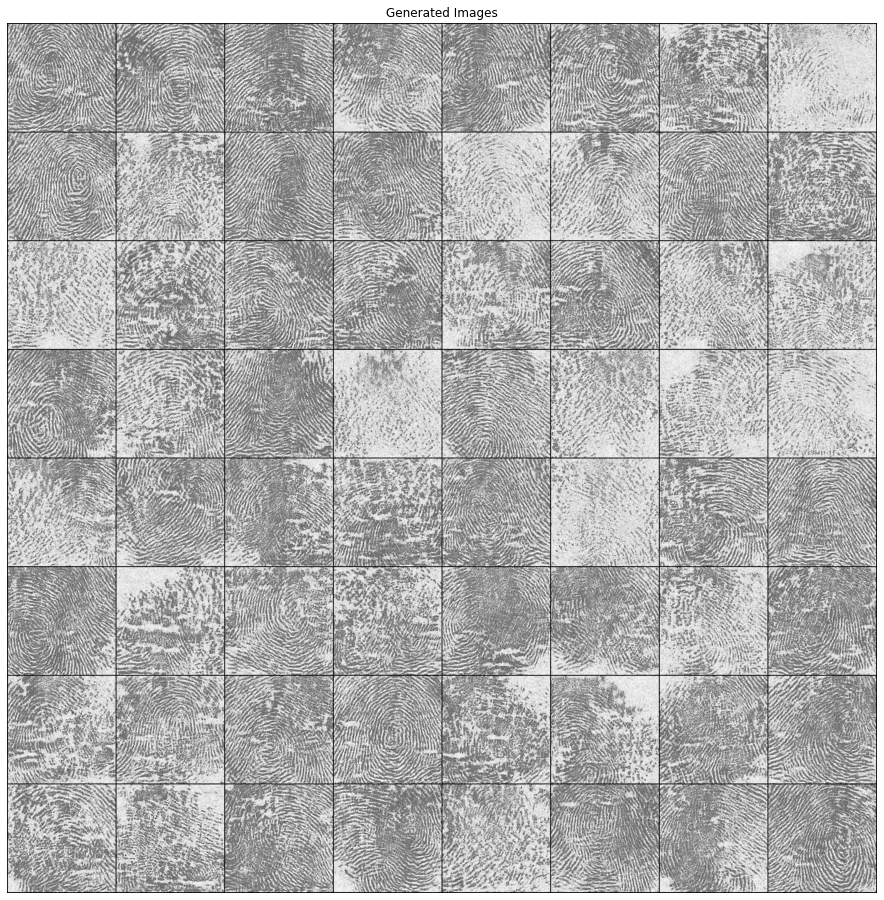

In [17]:
sample_size = 64

z = Variable(torch.randn(sample_size, *wgan.latent_shape))
if wgan.use_cuda:
    z = z.cuda()

img_list = []

for i in range(0, sample_size, batch_size):

      z = Variable(torch.randn(batch_size, *[1,1,image_size])).to(device)
      img_list = wgan.G(z).squeeze(0).cpu().detach()

grid = vutils.make_grid(img_list, nrow=8, padding=2, normalize=True)
print(len(img_list[0]))

plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()

### Upload Log Files to Tensorboard.dev

You can upload and view scalar values of `g_loss`, `d_loss` and `grad_penalty` logged over the course of training. The values will be displayed as a series of line plots. 

It is necessary to autherize the `Tensor.dev` API through your google account if you want to use this feature.

In [18]:
# !tensorboard dev upload --logdir $log_dir  --name $dataset_name   --description "Generating synthetic fingerprint images influenced by skin disease"

## Generate Synthetic Fingerprint Dataset

The trained model of WGAN-GP can be subsequently used to generate a dataset of synthetic fingerprint samples. The generator network takes a vector $z$ drawn from normal probability distribution $N(0,1)$ and transforms it into output $\tilde{x}$, which is the generated image sample.

&nbsp;

$ z \in R^{|latent\_dim|} $

$ \tilde{x} \in R^{|img\_size \times img\_size|}$

&nbsp;

$ G: R^{|z|} \rightarrow R^{|x|} $

$ \tilde{x} = G(z)$

&nbsp;

---
#### Note : Change the `target_location` to generate the synthetic fingerprint dataset in a different location

In [19]:
sample_number = 64

# target_location = 'drive/MyDrive/_Datasets_Generated/{}_generated/'.format(dataset_name)
target_location = dataset_name+'_generated'
sample_file_name = dataset_name

def generate_samples(n, filename, target_location):
  
    if not os.path.exists(target_location):
        os.makedirs(target_location)

    for i in range(0, sample_number, batch_size):

        z = Variable(torch.randn(batch_size, *[1,1,image_size])).to(device)
        img_list = wgan.G(z).squeeze(0)

        for j, img in enumerate(img_list):
          vutils.save_image(img, os.path.join(target_location, '{}_{:04}.png'.format(filename, i*64+j)), normalize=True)

generate_samples(sample_number, sample_file_name, target_location)